# Cumulated Graph of the Distance traveled 
# + Plot of Trajectories with different velocities:

This script provides the figure for cumulated distance traveled in a recording, with timebins of 10 minutes.


Code launched.
Reminder: 1min = 1800 frames, 1h= 108000, 5h = 540000, 12h = 1296000 frames


Start :  0


Entry (in frame) : 0


End :  218000


Entry (in frame) : 218000


Enter the name of the new FOLDER in which the images will be saved:  564


There will be 12 bins of 10min (18000 frames) in the graph.
The timebinList is: [0, 18000, 36000, 54000, 72000, 90000, 108000, 126000, 144000, 162000, 180000, 198000, 216000]

 This script will plot the total Distance traveled (in bins of 10 minutes) by the mice in the selected databases... 


 as well as the trajectories of the different mice (in bins of 1 hour) and for different velocities... 

E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221018_Amphet_Cage1_2-1Amphet.sqlite
The CURRENT expName is:  221018_Amphet_Cage1_2-1Amphet
Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:2 Name:B RFID:000004849319 Genotype:Amphet User1:None
Animal Id:1 Name:A RFID:000004849450 Genotype:NaCl User1:None
Animal Id:3 Name:C RFID:000004849076 Genotype:NaCl User1:None
000004849319
totalDistance  Id( 2 , None , None , None ) Min/maxFrame: ( 0 / 218000 ) Loaded ( 0  records loaded i

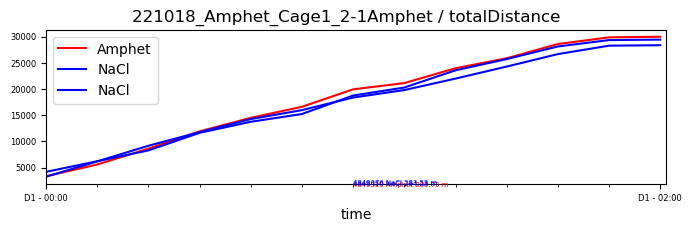

Animal Id:2 Name:B RFID:000004849319 Genotype:Amphet User1:None : Loading detection.
IN LOAD DETECTION !!!!!!!
SELECT FRAMENUMBER, MASS_X, MASS_Y, MASS_Z, FRONT_X, FRONT_Y, FRONT_Z, BACK_X, BACK_Y, BACK_Z,REARING,LOOK_UP,LOOK_DOWN FROM DETECTION WHERE ANIMALID=2 AND FRAMENUMBER>=0 AND FRAMENUMBER<=218000
Animal Id:2 Name:B RFID:000004849319 Genotype:Amphet User1:None   159489  detections loaded in 3.352245807647705 seconds.
Animal Id:1 Name:A RFID:000004849450 Genotype:NaCl User1:None : Loading detection.
IN LOAD DETECTION !!!!!!!
SELECT FRAMENUMBER, MASS_X, MASS_Y, MASS_Z, FRONT_X, FRONT_Y, FRONT_Z, BACK_X, BACK_Y, BACK_Z,REARING,LOOK_UP,LOOK_DOWN FROM DETECTION WHERE ANIMALID=1 AND FRAMENUMBER>=0 AND FRAMENUMBER<=218000
Animal Id:1 Name:A RFID:000004849450 Genotype:NaCl User1:None   168018  detections loaded in 2.9123990535736084 seconds.
Animal Id:3 Name:C RFID:000004849076 Genotype:NaCl User1:None : Loading detection.
IN LOAD DETECTION !!!!!!!
SELECT FRAMENUMBER, MASS_X, MASS_Y, MA

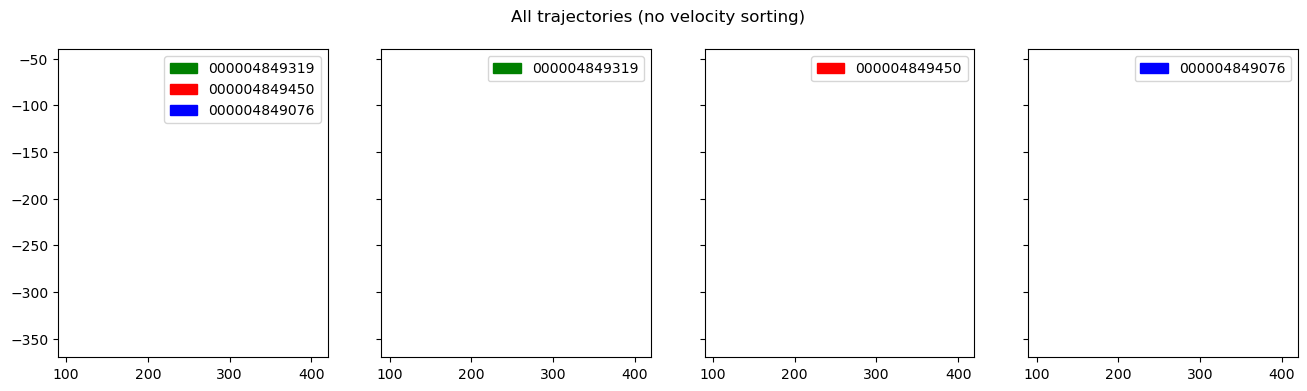

Heatmap
AnimalPool: plot Heatmap.
Compute trajectory of animal B


ValueError: min() arg is an empty sequence

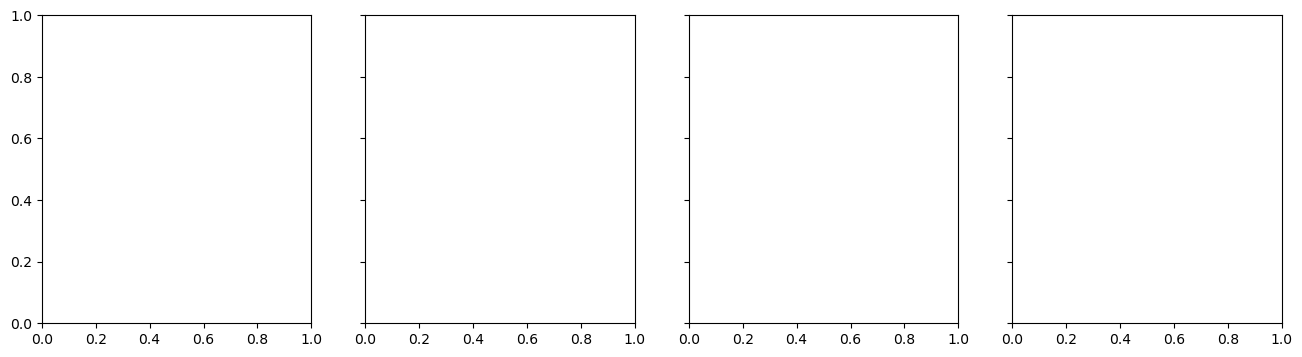

In [1]:
import sys
sys.path.insert(1, "../")

import sqlite3
from lmtanalysis.Animal import *
import matplotlib.pyplot as plt
from lmtanalysis.Event import *
from lmtanalysis.Measure import *

import lmtanalysis
from tkinter.filedialog import askopenfilename
from tabulate import tabulate
from collections import Counter
import collections
import xlsxwriter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
from lmtanalysis.FileUtil import getFilesToProcess
from lmtanalysis.Util import convert_to_d_h_m_s, getMinTMaxTInput,getFrameInput


def frameToTimeTicker(x, pos):
    vals= convert_to_d_h_m_s( x )
    return "D{0} - {1:02d}:{2:02d}".format( int(vals[0])+1, int(vals[1]), int(vals[2]) )
    

if __name__ == '__main__':
    
    print("Code launched.")
    
    #Choose the files to process, and ask for the Start and Enf frames.
    files = getFilesToProcess()
    print("Reminder: 1min = 1800 frames, 1h= 108000, 5h = 540000, 12h = 1296000 frames")
    tmin = getFrameInput("Start")
    tmax = getFrameInput("End")
    
    folderName = input("Enter the name of the new FOLDER in which the images will be saved: ")
    folderName_Cumul = folderName+"_cumul_graphs" #Folder for Cumulative distance graphs
    folderName_Traj = folderName+"_trajectories" # Folder for the trajectories with different speeds
       
    os.makedirs(folderName)
    os.makedirs(folderName+"/"+folderName_Cumul)
    os.makedirs(folderName+"/"+folderName_Traj)
    
    #Calculate the timebins of 10minutes:
    nbTimeBins = int((tmax-tmin)/18000) #10min = 18000frames
    timebins = []
    tenMinBin = 10*30*60 #Bins of 10 minutes = 18000 frames
    print(f"There will be {nbTimeBins} bins of 10min (18000 frames) in the graph.")
    for i in range(nbTimeBins+1):
        timebins.append(i * 18000)
        
    print(f"The timebinList is: {timebins}")   
    # print(f" with a length of {len(timebins)}. \n")
    
    # behaviorToPlot = input("Which behavior do you want to plot the Cumulated graph? (No choice here... totalDistance) : ")
    behaviorToPlot = "totalDistance"
    figName = behaviorToPlot
    
    print("\n This script will plot the total Distance traveled (in bins of 10 minutes) by the mice in the selected databases... \n")
    print("\n as well as the trajectories of the different mice (in bins of 1 hour) and for different velocities... \n")
    
    for file in files:
        
        animalTotalDistance = {}
        animalDistancePerBin = {}
        listCumulated = {}
        listValue = {}
        behaviorTimeLine = {}
        
        # Extract the File name (split path with '/' and remove the '.sqlite')
        print(file)
        split_filename = file.split("/")
        len_filename = len(split_filename)
        split_filename[len_filename-1]
        expName = split_filename[len_filename-1][0:-7] #Select the name of XP in the filename
        print("The CURRENT expName is: ", expName)
        
        # Connect to DB and create the pool of animals
        connection = sqlite3.connect( file )
        pool = AnimalPool( )
        pool.loadAnimals( connection )
        """        
        pool.loadDetection( start = tmin, end = tmax, lightLoad=True)
        """

        for animal in pool.animalDictionnary.keys():
            print( pool.animalDictionnary[animal].RFID )
            
            # Load the timeline of the event over all individuals
            behaviorTimeLine[animal] = EventTimeLine( connection, behaviorToPlot, idA=animal, minFrame=tmin, maxFrame=tmax )
#             behaviorTimeLine[animal].removeEventsBelowLength( maxLen = MIN_WATER_STOP_DURATION )

            print("Computing the distance:")
            pool.animalDictionnary[animal].loadDetection( start=tmin, end=tmax, lightLoad = True )
            animalTotalDistance[animal] = pool.animalDictionnary[animal].getDistance(tmin,tmax)/100 # Total distance in meters (m)
            animalDistancePerBin[animal] = pool.animalDictionnary[animal].getDistancePerBin(binFrameSize = tenMinBin , minFrame=tmin, maxFrame=tmax ) # in centimeters (m)
            
            print("\n")
            print(f"The animalDistancePerBin for animal {animal} is:")
            print(animalDistancePerBin[animal])
            print(f"of lenght {len(animalDistancePerBin[animal])}.")
        
        # Build the plot
        fig, ax = plt.subplots(1,1 , figsize=(8, 2 ) )
        ax = plt.gca() # get current axis
        #ax.set_ylim([ymin, ymax])
        
        #set x axis
        ax.set_xlabel("time")
        ax.set_xlim([0, tmax])
        formatter = matplotlib.ticker.FuncFormatter( frameToTimeTicker )
        ax.xaxis.set_major_formatter(formatter)
        ax.tick_params(labelsize=6 )
        ax.xaxis.set_major_locator(ticker.MultipleLocator( 18000 * 12 )) # 10min = 18000 frames
        ax.xaxis.set_minor_locator(ticker.MultipleLocator( 18000 ))
        
        totalDistance = {}
        timeBin = 1
        
        #Print the name and genotype of the animals on the graph, with the corresponding colors and the total distance traveled over the experiment
        maxHeight = max(animalDistancePerBin[1])
        print(f"the maximal Height is: {maxHeight}.")
        legendHeight = int(maxHeight/3) # At one third of the maximal y-value
        rfids_legend = []
        geno_legend = []
        
        for animal in pool.animalDictionnary.keys():
            rfids_legend.append(pool.animalDictionnary[animal].RFID[4:])
            geno_legend.append(pool.animalDictionnary[animal].genotype)

        print("\n")
        print(f"RFID legends: {rfids_legend}")
        print(f"Geno legends: {geno_legend}")
             
        for animal in pool.animalDictionnary.keys():
            # print(f"\n Animal {animal}")
            # listCumulated = []
            # listValue = behaviorTimeLine[animal].getDurationEventInTimeBin( tmin=tmin, tmax=tmax, binSize=timeBin*oneMinute)
            
            listValue[animal] = animalDistancePerBin[animal]
            
            cumul = 0 # To compute the cumulative value of the event (totalDistance here)
            cumulList = []
            for value in listValue[animal]:
                cumul+= value
                # listCumulated[animal].append(cumul)
                cumulList.append(cumul)
                
            totalDistance[animal]= cumulList # totalDistance is a dict with 'animal number' as key and the list of cumulated Distance in values
        
            # print(f"\n Total distance : {totalDistance[animal]} for animal : {animal}.")
        
        print("\n nbtimebins: ", nbTimeBins)
        
        # Check if timebins and totalDistance have the same size :
        # remove one timebin if not.
        while len(timebins) > len(totalDistance[1]):
            timebins.pop()
            print("popped last timebin value")  
        
#         # COLOR CODE FOR Cntnap2 experiments!
#         for animal in totalDistance:
#             if "+/+" in pool.animalDictionnary[animal].genotype:
#                 color = "blue"  # +/+ mice in BLUE
#             elif "+/-" in pool.animalDictionnary[animal].genotype:
#                 color = "orange"  # +/- mice in orange
#             elif "-/-" in pool.animalDictionnary[animal].genotype:
#                 color = "red"  # +/- mice in orange # -/- mice in RED
           
        # COLOR CODE FOR Amphetamine experiments!
        for animal in totalDistance:
            if "NaCl" in pool.animalDictionnary[animal].genotype:
                color = "blue"  # +/+ mice in BLUE
            elif "Amphet" in pool.animalDictionnary[animal].genotype:
                color = "red"  # +/- mice in orange # -/- mice in RED
            else:
                color = "orange"
        
        # # COLOR CODE FOR Magel-2 experiments!
        # for animal in totalDistance:
        #     if "WT_OXT" in pool.animalDictionnary[animal].genotype:
        #         color = "royalblue"  # +/+ mice in BLUE
        #     elif "WT_NaCl-" in pool.animalDictionnary[animal].genotype:
        #         color = "blue"  # +/- mice in orange
        #     elif "KO_OXT" in pool.animalDictionnary[animal].genotype:
        #         color = "firebrick"  # +/- mice in orange # -/- mice in RED
        #     elif "KO_NaCl" in pool.animalDictionnary[animal].genotype:
        #         color = "pink"  # +/- mice in orange # -/- mice in RED
        #     elif "Hetero_NaCl" in pool.animalDictionnary[animal].genotype:
        #         color = "black"  # +/- mice in orange # -/- mice in RED
            
            totalDistValue = max(totalDistance[animal])
            print(f"\n TotalDistance of animal {animal}: {round(totalDistValue, 2)}")
            
            ax.text(30*60*60, legendHeight, "{} {} {} m".format(pool.animalDictionnary[animal].RFID[5:], 
                                                                pool.animalDictionnary[animal].genotype,
                                                                round(totalDistValue/100,2)), color = color, fontsize=5)
            
            legendHeight += int(maxHeight/20) 
            
            ax.plot(timebins, totalDistance[animal] , color= color) # color= getAnimalColor( animal )

                
        ax.legend(geno_legend) #ADD THE GENOTYPE AS LEGEND
        fig.suptitle(f"{expName} / {behaviorToPlot}")

        figName_cumul = f"FigCumul-{behaviorToPlot}_{expName}.png"
        print (behaviorToPlot)
        print(expName)
        print ("Saving figure... \n" , figName )
        
        # os.makedirs(folderName_Cumul)
        
        fig.savefig(folderName+"/"+folderName_Cumul+"/"+figName_cumul, dpi=200)
        
        plt.show()
        plt.close(fig)
        
        #### NOW PLOT THE TRAJECTORIES FOR THE ENTIRE SESSION AND IN BINS OF ONE HOUR :
        #### And for different speeds
        
        figName_traj = f"FigTraj_{expName}"
        
        connection = sqlite3.connect( file ) # connect to database
        pool.loadDetection( start = tmin, end = tmax) # load all detection (positions) of all animals within the timebin entered    
        # pool.plotTrajectory(title = "All trajectories (no velocity sorting)", saveFile = folderName+"/"+folderName_Traj+"/"+figName_traj+"_All.png") # plot and show trajectory
        
        pool.filterDetectionByArea( 0, 50, 0, 50 ) # filter detection by area (in cm (xstart, xend, ystart, yend) from top left)
        pool.plotTrajectory(title = "All trajectories (no velocity sorting)", scatter = True, 
                            saveFile = folderName+"/"+folderName_Traj+"/"+figName_traj+"_All.png") # plot and show trajectory
        
        print("Heatmap")
        pool.plotHeatmap()
        
        pool.filterDetectionByInstantSpeed( 0, 2 ) # filter detection by animalSpeed (between 0 and 2 cm/s)
        pool.plotTrajectory(title = "Slow Speed (0-2 cm/s) = IMMOBILITY", 
                            saveFile = folderName+"/"+folderName_Traj+"/"+figName_traj+"_slow.png", 
                            scatter = True) # plot and show trajectory
        pool.plotHeatmap()
        
        pool.loadDetection( start = tmin, end = tmax)
        pool.filterDetectionByInstantSpeed( 2, 20 ) # filter detection by animalSpeed (between 2 and 20 cm/s)
        pool.plotTrajectory(title = "Intermediate Speed (2-20cm/s) = WALKING", 
                            saveFile = folderName+"/"+folderName_Traj+"/"+figName_traj+"_inter.png", 
                            scatter = True) # plot and show trajectory
        pool.plotHeatmap()
        
        pool.loadDetection( start = tmin, end = tmax)
        pool.filterDetectionByInstantSpeed( 20, 50 ) # filter detection by animalSpeed (between 20 and 50 cm/s)
        pool.plotTrajectory(title = "Fast Speed (20-50cm/s) = RUNNING", 
                            saveFile = folderName+"/"+folderName_Traj+"/"+figName_traj+"_fast.png", 
                            scatter = True) # plot and show trajectory
        pool.plotHeatmap()

        oneHourBin = tenMinBin * 6
        bin_start = tmin
        bin_end = bin_start + oneHourBin
        
        for i in range(int(nbTimeBins/6)):
            pool.loadDetection( start = bin_start + i*oneHourBin, end = bin_end + i*oneHourBin) # load all detection (positions) of all animals within the timebin entered
            pool.plotTrajectory(title = f"All trajectories (no velocity sorting), bin-{i+1} ({bin_start+ i*oneHourBin}-{bin_end+ i*oneHourBin})", 
                                saveFile = folderName+"/"+folderName_Traj+"/"+figName_traj+"_bin-"+str(i+1)+".png", 
                                scatter = True) # plot and show trajectory
            pool.plotHeatmap()
            
            pool.filterDetectionByInstantSpeed(0, 1) # IMMOBILITY detection (velocity between 0 and 1 cm/s)
            pool.plotTrajectory(title = f"IMMOBILITY (0-1 cm/s), bin-{i+1}", 
                                saveFile = folderName+"/"+folderName_Traj+"/"+figName_traj+"_Immo-Bin"+str(i+1)+".png", 
                                scatter = True) # plot and show trajectory
            pool.plotHeatmap()
            
            pool.loadDetection( start = bin_start + i*oneHourBin, end = bin_end + i*oneHourBin) # load all detection (positions) of all animals within the timebin entered
            pool.filterDetectionByInstantSpeed(1, 50) # Activity detection (velocity between 1 and 50 cm/s)
            pool.plotTrajectory(title = f"ACTIVITY (1-50 cm/s), bin-{i+1}", 
                                saveFile = folderName+"/"+folderName_Traj+"/"+figName_traj+"_Activ-Bin"+str(i+1)+".png", 
                                scatter = True) # plot and show trajectory
            pool.plotHeatmap()
        
    connection.close() #Stop connection to the DBs
        
    print( "*** ALL JOBS DONE *** ")


In [26]:
xList

NameError: name 'xList' is not defined

# STEP-2: Show TRAJECTORIES depending on the speed of the mice !

In [7]:
folderName_SpeedGraphs = input("Enter the name of the new folder For the TRAJECTORIES: ")
os.makedirs(folderName_SpeedGraphs)


SyntaxError: invalid syntax (1995294563.py, line 3)

## Display trajectories of animals
* For this example we filter data from 0 to 1 hour
* Trajectories are plotted considering the kinect resolution.
    * 30 detections per second
    * 512x424 infra red sensor resolution

In [ ]:
for file in files:
    connection = sqlite3.connect( file ) # connect to database
    animalPool = AnimalPool() # create an animalPool, which basically contains your animals
    animalPool.loadAnimals( connection ) # load infos about the animals
    animalPool.loadDetection( start = 0, end = oneHour ) # load all detection (positions) of all animals for the first hour
    
    animalPool.filterDetectionByInstantSpeed( 0, 2 ) # filter detection by animalSpeed (between 0 and 2 cm/s)

    animalPool.plotTrajectory() # plot and show trajectory
    
        

    # plot and show trajectory
    animalPool.plotTrajectory( title="Trajectories filtered by speed (max 2) ")

## Filter trajectories : keep tracks which are slower than 2cm/s = IMMOBILITY

In [ ]:
for file in files:

    # connect to database
    connection = sqlite3.connect( file )

    # create an animalPool, which basically contains your animals
    animalPool = AnimalPool()

    # load infos about the animals
    animalPool.loadAnimals( connection )

    # load all detection (positions) of all animals for the first hour
    animalPool.loadDetection( start = 0, end = oneHour )

    # filter detection by animalSpeed (speed is in centimeters per second)
    animalPool.filterDetectionByInstantSpeed( 0, 2 )

    # plot and show trajectory
    animalPool.plotTrajectory( title="Trajectories filtered by speed (max 2) ")

## Filter trajectories : keep tracks which are HIGHER than 2cm/s (slower than 30!)

In [ ]:
for file in files:

    # connect to database
    connection = sqlite3.connect( file )

    # create an animalPool, which basically contains your animals
    animalPool = AnimalPool()

    # load infos about the animals
    animalPool.loadAnimals( connection )

    # load all detection (positions) of all animals for the first hour
    animalPool.loadDetection( start = 0, end = oneHour )

    # filter detection by animalSpeed (speed is in centimeters per second)
    animalPool.filterDetectionByInstantSpeed( 2, 30 )

    # plot and show trajectory
    animalPool.plotTrajectory( title="Trajectories filtered by speed (max 2) ")

## Filter trajectories : keep tracks which are HIGHER than 30cm/s (TRACKING ERRORS ?!)

In [ ]:
for file in files:

    # connect to database
    connection = sqlite3.connect( file )

    # create an animalPool, which basically contains your animals
    animalPool = AnimalPool()

    # load infos about the animals
    animalPool.loadAnimals( connection )

    # load all detection (positions) of all animals for the first hour
    animalPool.loadDetection( start = 0, end = oneHour )

    # filter detection by animalSpeed (speed is in centimeters per second)
    animalPool.filterDetectionByInstantSpeed( 30, 1000 )

    # plot and show trajectory
    animalPool.plotTrajectory( title="Trajectories filtered by speed (max 2) ")

## Filter trajectories : keep tracks which are BETWEEN 10 and 20cm/s (WALKING ?!)

In [ ]:
for file in files:

    # connect to database
    connection = sqlite3.connect( file )

    # create an animalPool, which basically contains your animals
    animalPool = AnimalPool()

    # load infos about the animals
    animalPool.loadAnimals( connection )

    # load all detection (positions) of all animals for the first hour
    animalPool.loadDetection( start = 0, end = oneHour )

    # filter detection by animalSpeed (speed is in centimeters per second)
    animalPool.filterDetectionByInstantSpeed( 10, 20)

    # plot and show trajectory
    animalPool.plotTrajectory( title="Trajectories filtered by speed (max 2) ")

## Filter trajectories : keep tracks which are BETWEEN 20 and 40cm/s (RUNNING ?!)

In [ ]:
for file in files:

    # connect to database
    connection = sqlite3.connect( file )

    # create an animalPool, which basically contains your animals
    animalPool = AnimalPool()

    # load infos about the animals
    animalPool.loadAnimals( connection )

    # load all detection (positions) of all animals for the first hour
    animalPool.loadDetection( start = 0, end = oneHour )

    # filter detection by animalSpeed (speed is in centimeters per second)
    animalPool.filterDetectionByInstantSpeed( 20, 40)

    # plot and show trajectory
    animalPool.plotTrajectory( title="Trajectories filtered by speed (max 2) ")